### TF-IDF + Log Reg

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import dagshub

In [14]:
def load_corpus(DATASET_PATH, CODE_COLUMN):
    df = pd.read_csv(DATASET_PATH, encoding='utf-8', comment='#')#, quoting=csv.QUOTE_NONE, error_bad_lines=False)#, sep=','
    corpus = df[CODE_COLUMN]
    test_size = 0.1
    test_rows = round(df.shape[0]*test_size)
    train_rows = df.shape[0] - test_rows
    train_corpus = df[CODE_COLUMN][0:test_rows]
    test_corpus = df[CODE_COLUMN][train_rows:]
    return df, corpus

In [3]:
def tfidf_transform(corpus, params):
#     tfidf = TfidfVectorizer(min_df=5
#                             , max_df = 0.3
#                             , ngram_range = (1,2)
#                             , smooth_idf = True
#                            )
    tfidf = TfidfVectorizer(params)
    features = tfidf.fit_transform(corpus)
    # for_pred = tfidf.transform(test_corpus)
    return features

In [4]:
def logreg_evaluate(df, features):
    tag_to_predict = 'preprocessing'
    X_train, X_test, y_train, y_test = train_test_split(features[0:len(df[tag_to_predict])], df[tag_to_predict], test_size=0.25)
    clf = LogisticRegression(random_state=421).fit(X_train, y_train)
    # clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    f1 = f1_score(y_pred, y_test)
    print(f'Mean Accuracy {round(accuracy*100, 2)}%')
    print(f'F1-score {round(f1*100, 2)}%')
    errors = y_test - y_pred
    plt.hist(errors)
    plot_precision_recall_curve(clf, X_test, y_test)
    plot_confusion_matrix(clf, X_test, y_test, values_format='d')
    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h
    conf_interval = mean_confidence_interval(errors, 0.95)
    print(conf_interval)
    metrics = {'test_accuracy': accuracy
               , 'test_f1_score': f1}
    return metrics

loaded
tfidf-ed
Mean Accuracy 90.22%
F1-score 92.24%
(0.02093279471171502, 0.01650174984637589, 0.025363839577054154)
finished


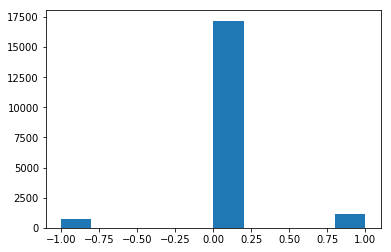

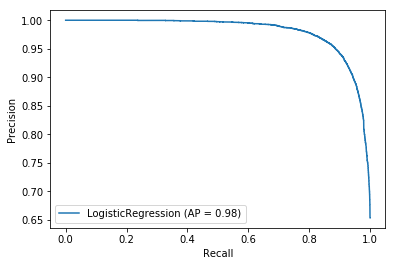

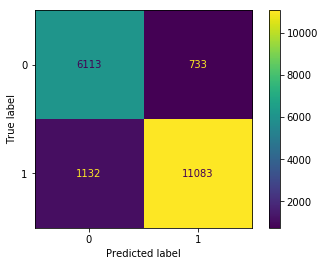

In [15]:
if __name__ == '__main__':
    DATASET_PATH = './data/code_blocks_regex_nocomments_30.csv'
    CODE_COLUMN = 'code'
    df, corpus = load_corpus(DATASET_PATH, CODE_COLUMN)
    nrows = df.shape[0]
    print("loaded")
    
    params = {'min_df': 5
             , 'max_df': 0.3
             , 'smooth_idf': True}
    data_meta = {'DATASET_PATH': DATASET_PATH
                ,'nrows': nrows}
    
    features = tfidf_transform(corpus, params)
    print("tfidf-ed")
    with dagshub.dagshub_logger() as logger:
        metrics = logreg_evaluate(df, features)
        logger.log_hyperparams(data_meta)
        logger.log_hyperparams(params)
        logger.log_metrics(metrics)
    print("finished")